### Load relevant data

In [8]:
from experiments_utils.fetching import ResultsManager

In [9]:
r = ResultsManager("iclr_experiments_3")

In [10]:
ret_sunle_50000 = r.fetch_one_result(num_samples=(50000, *10 * (10000,))).result

In [4]:
ret_sunle_100000 = r.fetch_one_result(num_samples=(100000, *10 * (10000,))).result

In [7]:
ret_sunle_100000.train_results.config.training.sampling_cfg

MCMCAlgorithmFactory(config=MCMCConfig(num_samples=1000, kernel_factory=NUTSKernelFactory(config=NUTSConfig(step_size=0.1, C=None, max_tree_depth=5), kernel_cls=<class 'sbi_ebm.samplers.kernels.numpyro_nuts.NUTSKernel'>), num_chains=1000, thinning_factor=10, record_trajectory=True, num_warmup_steps=50, adapt_step_size=True, adapt_mass_matrix=False, resample_stuck_chain_at_warmup=False, target_accept_rate=0.2, progress_bar=False, warmup_method='sbi_ebm', init_using_log_l_mode=False, init_using_log_l_mode_num_opt_steps=50))

In [10]:
import numpy as np
lims = np.asarray([[ 0.0000000e+00,  5.0000000e+02],
       [ 0.0000000e+00,  7.5000000e+00],
       [ 0.0000000e+00,  8.0000000e+00],
       [ 0.0000000e+00,  6.0000000e+01],
       [ 0.0000000e+00,  1.5000000e+01],
       [ 2.5000000e+01,  1.5000000e+02],
       [ 0.0000000e+00,  2.0000000e-02],
       [ 0.0000000e+00,  9.9999998e-03],
       [ 0.0000000e+00,  2.0000000e+02],
       [ 0.0000000e+00,  2.5000000e+00],
       [ 2.0000000e+00,  1.2000000e+01],
       [ 1.0000000e+01,  6.0000000e+01],
       [ 0.0000000e+00,  1.0000000e+01],
       [ 0.0000000e+00,  1.2500000e+02],
       [ 0.0000000e+00,  5.9999999e-02],
       [ 9.9999998e-03,  3.9999999e-02],
       [ 0.0000000e+00,  6.0000000e+02],
       [ 0.0000000e+00,  1.2500000e+01],
       [ 0.0000000e+00,  4.0000000e+00],
       [ 3.0000000e+01,  6.0000000e+01],
       [ 0.0000000e+00,  5.0000000e+00],
       [ 5.0000000e+01,  1.5000000e+02],
       [ 0.0000000e+00,  5.9999999e-02],
       [ 0.0000000e+00,  3.9999999e-02],
       [-1.8420681e+01, -4.6051702e+00],
       [-1.8420681e+01, -6.9077554e+00],
       [-1.8420681e+01, -6.9077554e+00],
       [-1.8420681e+01, -6.9077554e+00],
       [-1.8420681e+01, -6.9077554e+00],
       [-1.8420681e+01, -6.9077554e+00],
       [-1.8420681e+01, -6.9077554e+00]], dtype=np.float32)

## Computing posterior accuracy

### Premise

In [11]:
from jax import jit

@jit
def energy_scoring_rule(X, x):
    beta = 1
    term_1 = 2 / X.shape[0] * jnp.sum(jnp.sqrt(jnp.sum(jnp.square(X - x), axis=-1))) 
    term_2 = 1 / (X.shape[0] * (X.shape[0] -1 )) *jnp.sum(jnp.sqrt(jnp.sum(jnp.square(X[:, None, :] - X[None, :, :]), axis=-1)))
    return term_1 - term_2

In [12]:
import torch
import numpy as np
from sbi_ebm.sbibm.tasks import get_task
t = get_task("pyloric")
true_x_obs = t.get_observation(2)

In [ ]:
thetas, xs = t.get_precomputed_dataset()
xs = xs[:1000000]
prior_pred_valid = xs[(xs!=-99).all(1)]

xs_mean = prior_pred_valid.mean(0)
xs_std = prior_pred_valid.std(0)
# z score the x
prior_pred_valid_zscored = (prior_pred_valid - xs_mean)/xs_std
x_o_zscored = (t.get_observation(2)-xs_mean)/xs_std
median_dist_prior = torch.sqrt(torch.sum((prior_pred_valid_zscored - x_o_zscored)**2, 1).median())

# median_dist_posterior = torch.sqrt(torch.sum((post_pred_valid_zscored - x_o_zscored)**2, 1).median())
# post_pred_valid_zscored = (post_pred_valid - xs_mean)/xs_std

In [14]:
import jax.numpy as jnp
import pickle
from flax import struct

class PyloricMetrics(struct.PyTreeNode):
    energy_values_per_round: list
    energy_values_z_scored_per_round: list
    median_distance_x_obs: list
    num_valid_obs_per_round: list
    frac_valid_obs_per_round: list
    num_simulations: list
    

In [15]:
def compute_metric_sunle(ret):
    energy_values_per_round_sunle = []
    energy_values_z_scored_per_round_sunle = []
    median_distance_x_obs_sunle = []
    num_valid_obs_per_round_sunle = []
    frac_valid_obs_per_round_sunle = []
    num_simulations = []
    
    
    from sbi_ebm.sbibm.sbi_ebm import TrainEvalTresults
    if isinstance(ret, TrainEvalTresults):
        srr = ret.train_results.single_round_results
    else:
        srr = ret


    for i in range(len(srr)):
        # best_thetas = ret.train_results.single_round_results[r].posterior_samples

        xs_unle_i = srr[i].complete_dataset.observations[
            0 if i == 0 else len(srr[i-1].complete_dataset.observations): len(srr[i].complete_dataset.observations)
        ]
        
        is_valid_mask = jnp.all(jnp.isfinite(xs_unle_i), axis=1)
        num_valid = jnp.sum(is_valid_mask)
        # print(num_valid)

        xs_unle_i_valid = xs_unle_i[is_valid_mask]
        xs_unle_i_valid_zscored = (torch.from_numpy(np.array(xs_unle_i_valid)) - xs_mean)/xs_std

        # xs_unle_i_valid_mean = jnp.mean(xs_unle_i_valid, axis=0)
        # xs_unle_i_valid_std = jnp.std(xs_unle_i_valid, axis=0)
        # xs_unle_i_valid_zscored = (xs_unle_i_valid - lims_low) / (lims_high - lims_low)
        # true_x_obs_zscored = (jnp.array(true_x_obs) - lims_low) / (lims_high - lims_low)
        energy_val_zscored = energy_scoring_rule(jnp.array(xs_unle_i_valid_zscored), jnp.array(x_o_zscored))
        energy_values_z_scored_per_round_sunle.append(energy_val_zscored.item())

        energy_val = energy_scoring_rule(xs_unle_i_valid, jnp.array(true_x_obs))
        energy_values_per_round_sunle.append(energy_val.item())

        num_valid_obs_per_round_sunle.append(num_valid)
        frac_valid_obs_per_round_sunle.append(num_valid / len(xs_unle_i))


        median_dist_posterior = torch.sqrt(torch.sum((xs_unle_i_valid_zscored - x_o_zscored)**2, 1).median())
        median_distance_x_obs_sunle.append(median_dist_posterior.item())

        num_simulations.append(len(srr[i].complete_dataset.observations))
        # xs = s(torch.from_numpy(np.array(best_thetas[:1000])))
        # print(f"num_valid: {xs.isfinite().all(1).sum()}")
        # xs_unle_valid = xs[xs.isfinite().all(1)]
    return PyloricMetrics(
        energy_values_per_round_sunle,
        energy_values_z_scored_per_round_sunle,
        median_distance_x_obs=median_distance_x_obs_sunle,
        num_valid_obs_per_round=num_valid_obs_per_round_sunle,
        frac_valid_obs_per_round=frac_valid_obs_per_round_sunle,
        num_simulations=num_simulations
    )

In [16]:
import pickle
import jax.numpy as jnp 

def compute_metrics_snvi():
    energy_values_per_round_snle_fKL = []
    energy_values_z_scored_per_round_snle_fKL = []
    num_valid_obs_per_round_snle_fKL = []
    frac_valid_obs_per_round_snle_fKL = []
    median_distance_x_obs_snle_fKL = []
    num_simulations=[]

    for i in range(30):
        with open(f'snle_fKL/data_{i}.pkl', 'rb') as f:
            xs_snle_i = pickle.load(f)

        valid_mask = ((xs_snle_i - (-99.)) != 0).all(1)
        num_valid = valid_mask.sum().item()

        xs_snle_i_valid = xs_snle_i[valid_mask]
        xs_snle_i_valid_zscored = (xs_snle_i_valid - xs_mean)/xs_std

        energy_val = energy_scoring_rule(jnp.array(xs_snle_i_valid), jnp.array(true_x_obs))
        energy_val_zscored = energy_scoring_rule(jnp.array(xs_snle_i_valid_zscored), jnp.array(x_o_zscored))

        energy_values_z_scored_per_round_snle_fKL.append(energy_val_zscored.item())
        energy_values_per_round_snle_fKL.append(energy_val.item())

        num_valid_obs_per_round_snle_fKL.append(valid_mask.sum().item())
        frac_valid_obs_per_round_snle_fKL.append(valid_mask.sum().item() / len(xs_snle_i))

        post_pred_valid_zscored = (torch.from_numpy(np.array(xs_snle_i_valid)) - xs_mean)/xs_std
        median_dist_posterior = torch.sqrt(torch.sum((post_pred_valid_zscored - x_o_zscored)**2, 1).median())
        median_distance_x_obs_snle_fKL.append(median_dist_posterior.item())
        
        if i == 0:
            num_simulations.append(50000)
        else:
            num_simulations.append(num_simulations[-1] + 10000)
            

    return PyloricMetrics(
        energy_values_per_round_snle_fKL,
        energy_values_z_scored_per_round_snle_fKL,
        median_distance_x_obs=median_distance_x_obs_snle_fKL,
        num_valid_obs_per_round=num_valid_obs_per_round_snle_fKL,
        frac_valid_obs_per_round=frac_valid_obs_per_round_snle_fKL,
        num_simulations=num_simulations
    )

In [17]:
mets_sunle_100000 = compute_metric_sunle(ret_sunle_100000)
mets_sunle_50000 = compute_metric_sunle(ret_sunle_50000)
mets_snvi = compute_metrics_snvi()

### Posterior Accuracy

In [18]:
def tree_any(function, tree):
    from jax.tree_util import tree_map
    from jax.flatten_util import ravel_pytree
    import jax.numpy as jnp
    mapped_tree = tree_map(function, tree)
    return jnp.any(ravel_pytree(mapped_tree)[0])

In [19]:
from sbi_ebm.samplers.inference_algorithms.mcmc.base import _MCMCChain, _MCMCChainConfig
from sbi_ebm.samplers.kernels.mala import MALAConfig, MALAKernelFactory
from sbi_ebm.distributions import DoublyIntractableLogDensity, ThetaConditionalLogDensity, maybe_wrap

from sbi_ebm.pytypes import Array, LogDensity_T, Numeric, PRNGKeyArray, PyTreeNode
from sbi_ebm.samplers.inference_algorithms.base import (
    InferenceAlgorithm, InferenceAlgorithmConfig, InferenceAlgorithmFactory, InferenceAlgorithmInfo,
    InferenceAlgorithmResults)
from sbi_ebm.samplers.kernels.adaptive_mala import AdaptiveMALAState
from sbi_ebm.samplers.kernels.hmc import HMCInfo, HMCKernel, HMCKernelFactory
from sbi_ebm.samplers.kernels.mala import MALAConfig, MALAKernelFactory
from sbi_ebm.samplers.kernels.nuts import NUTSInfo, NUTSKernelFactory
from sbi_ebm.samplers.kernels.savm import SAVMState


def adam_initialize_doubly_intractable(theta, target_log_prob_fn, key, num_steps=50, learning_rate=0.05, num_likelihood_sampler_steps: int =100):
    """Use Adam optimizer to get a reasonable initialization for HMC algorithms.

    Args:
      x: Where to initialize Adam.
      target_log_prob_fn: Unnormalized target log-density.
      num_steps: How many steps of Adam to run.
      learning_rate: What learning rate to pass to Adam.

    Returns:
      Optimized version of x.
    """
    import optax
    import jax

    init_mcmc_chain = _MCMCChain(_MCMCChainConfig(
        MALAKernelFactory(MALAConfig(1.0, None)), num_steps=num_likelihood_sampler_steps // 2, num_warmup_steps=num_likelihood_sampler_steps // 2,
        adapt_mass_matrix=False, adapt_step_size=True, target_accept_rate=0.5, record_trajectory=True
    ), ThetaConditionalLogDensity(target_log_prob_fn.log_likelihood, theta), )
    init_mcmc_chain = init_mcmc_chain.init(target_log_prob_fn.x_obs)
    init_mcmc_chain, _ = init_mcmc_chain.run(key=random.fold_in(key, 0))

    def update_step(input_, i):
        theta, adam_state, mcmc_chain, lr  = input_

        _, g_log_prior = jax.tree_map(lambda x: -x, jax.value_and_grad(target_log_prob_fn.log_prior)(theta))
        _, g_log_lik_unnormalized = jax.tree_map(lambda x: -x, jax.value_and_grad(target_log_prob_fn.log_likelihood)(theta, target_log_prob_fn.x_obs))

        assert isinstance(mcmc_chain, _MCMCChain)
        assert isinstance(mcmc_chain.log_prob, ThetaConditionalLogDensity)
        mcmc_chain = mcmc_chain.replace(log_prob=mcmc_chain.log_prob.replace(theta=theta))
        new_mcmc_chain, results = mcmc_chain.run(key=random.fold_in(key, i))

        # g_log_normalizer = target_log_prob_fn.log_likelihood(theta, results.final_state.x)
        print(results.chain.x.shape)
        g_log_normalizer = jnp.average(vmap(target_log_prob_fn.log_likelihood, in_axes=(None, 0))(theta, results.chain.x), axis=0)
        g =  g_log_prior + g_log_lik_unnormalized + g_log_normalizer

        # updates, new_adam_state = optax.adam(0.001).update(g, adam_state)
        updates, new_adam_state = optax.adam(lr).update(g, adam_state)
        new_theta = optax.apply_updates(theta, updates)

        # has_nan = tree_any(lambda x: jnp.isfinite(x), (new_theta, target_log_prob_fn(new_theta), updates, new_adam_state, g, mcmc_chain))
        has_nan = tree_any(lambda x: jnp.isnan(x), (target_log_prob_fn(new_theta), new_theta))
        has_inf = tree_any(lambda x: jnp.isinf(x), (target_log_prob_fn(new_theta), new_theta))

        new_ret = jax.lax.cond(
            has_nan,
            lambda _: (theta, optax.adam(lr/1.5).init(theta), new_mcmc_chain, lr/1.5),
            lambda _: (new_theta, new_adam_state, new_mcmc_chain, lr),
            None
        )
        return new_ret, (new_ret, has_nan, has_inf)

    init_state = optax.adam(learning_rate).init(theta)
    # theta, _, _, final_lr, final_arr  = jax.lax.fori_loop(1, num_steps, update_step, (theta, init_state, init_mcmc_chain, learning_rate, arr))
    (theta, _, _, final_lr), traj   = jax.lax.scan(
        update_step,
        (theta, init_state, init_mcmc_chain, learning_rate),
        jnp.arange(1, num_steps+1),
    )
    # print(traj[-1])
    # print(final_lr)
    # print(final_arr)

    return traj[0][0]

In [20]:
from sbi_ebm.distributions import maybe_wrap
from sbi_ebm.sbibm.tasks import JaxTask, get_task
from sbi_ebm.distributions import DoublyIntractableLogDensity, maybe_wrap_log_l

from sbi_ebm.sbibm.tasks import JaxTask, get_task
from numpyro.distributions import TransformedDistribution
from jax import jit, random

key = random.PRNGKey(1)
def get_posterior_map(posterior, theta0, key, learning_rate=0.0005, num_steps=500, num_likelihood_sampler_steps=200):
    z_scored_posterior = DoublyIntractableLogDensity(
        log_prior=maybe_wrap(posterior._prior_zscored_space),
        log_likelihood=maybe_wrap_log_l(
            lambda theta, x: posterior.calibration_net_log_prob(theta) + posterior._log_likelihood_zscored_space(theta, x)
        ),
        x_obs=posterior.x_transform.inv(posterior.x)
    )
    # from sbi_ebm.samplers.inference_algorithms.mcmc.base import adam_initialize_doubly_intractable
    key, subkey = random.split(key)
    
    theta0_zscored = posterior.z_transform.inv(theta0)
    
    thetafinal_zscored= adam_initialize_doubly_intractable(
        theta0_zscored, z_scored_posterior, subkey, num_steps=num_steps, learning_rate=learning_rate,
        num_likelihood_sampler_steps=num_likelihood_sampler_steps
    )
    # return thetafinal_zscored
    return vmap(lambda x: posterior.z_transform(x))(thetafinal_zscored)

## Plot posterior predictive observations

In [22]:
from sbi_ebm.sbibm.tasks import get_task
task = get_task("pyloric")
task.summary = None

simulator = task.get_simulator(
    num_cores=1,
    verbose=0,
    sim_type="sequential"
)

In [23]:
from jax import vmap, jit
posterior = ret_sunle_100000.train_results.single_round_results[-2].posterior
posterior_samples = ret_sunle_100000.train_results.single_round_results[-2].posterior_samples

theta_mean = jnp.mean(posterior_samples, axis=0)

key = random.PRNGKey(0)
map_hist = get_posterior_map(
        posterior, theta_mean,
        random.fold_in(key, 1), learning_rate=1e-2, num_steps=500, num_likelihood_sampler_steps=100,
)

finding good initial position
finding good initial position
(50, 15)


In [24]:
import matplotlib.pyplot as plt
def plot_diff(hist):
    diffs = jnp.sum(jnp.square(hist[1:] - hist[:-1]), axis=1)
    f, ax = plt.subplots()
    ax.plot(jnp.log10(diffs))

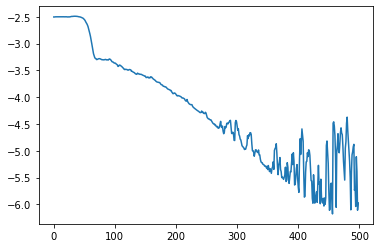

In [25]:
plot_diff(ret_sunle_100000.train_results.posterior.z_transform.inv(map_hist))

In [26]:
theta_map = map_hist[-1]

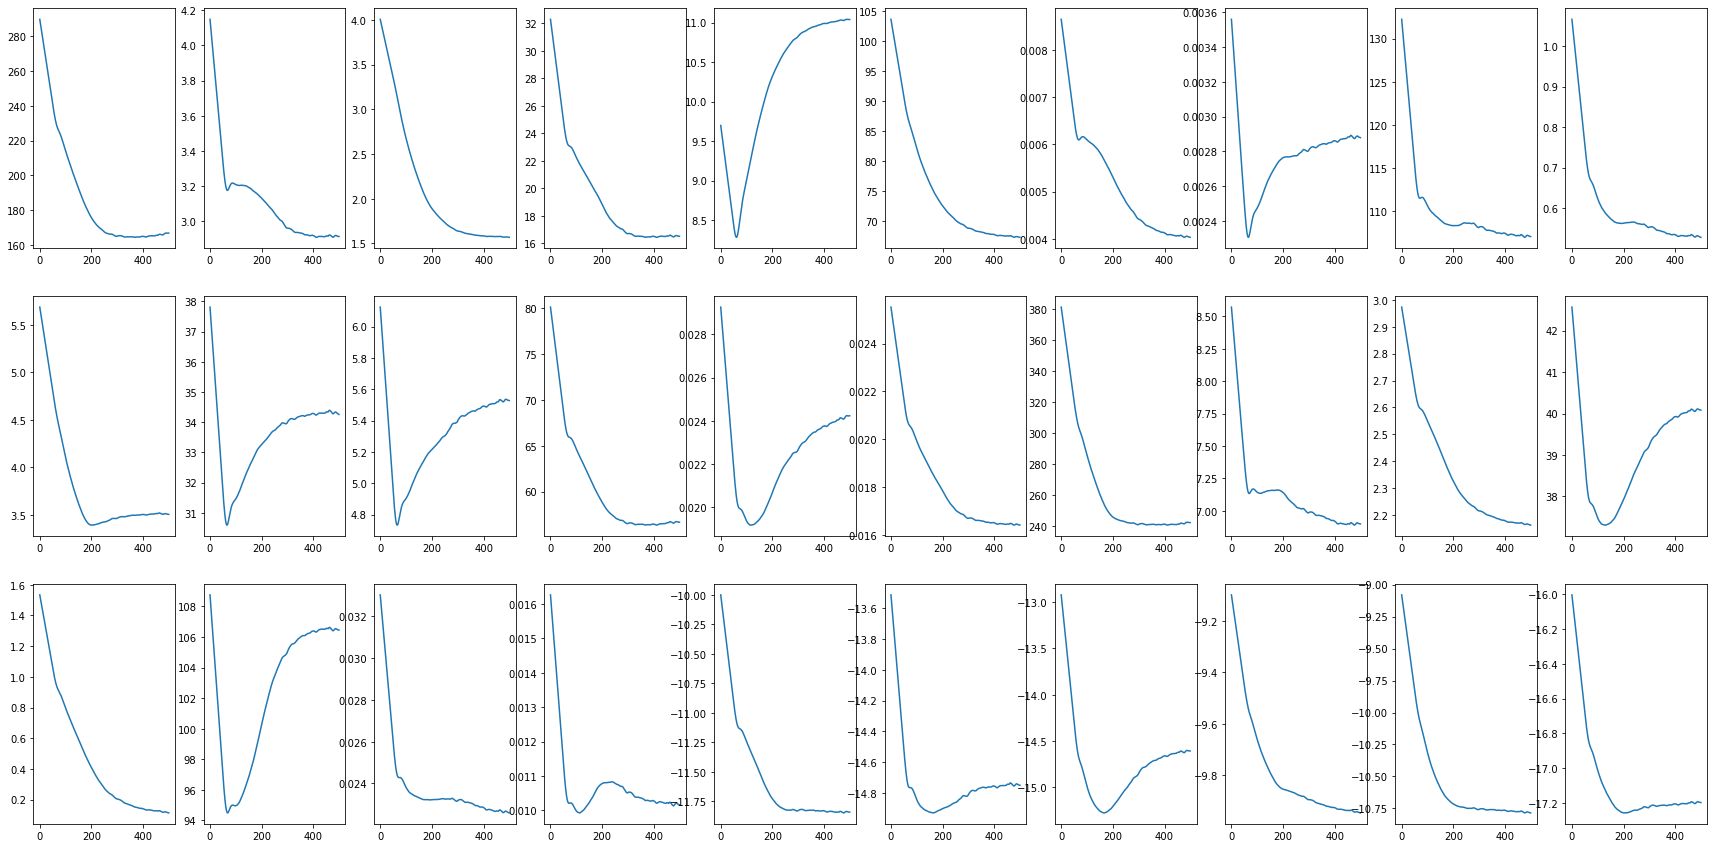

In [27]:
import matplotlib.pyplot as plt
f, axs = plt.subplots(ncols=10, nrows=3, figsize=(30, 15))

col_idx = 0
for i, axs_row in enumerate(axs):
    for j, ax in enumerate(axs_row):
        ax.plot(map_hist[:, col_idx])
        col_idx += 1

In [28]:
import torch
import numpy as np

torch.manual_seed(1)

x_mean = simulator(torch.from_numpy(np.array(theta_mean)))
x_mean = task.unflatten_data(x_mean)

x_map = simulator(torch.from_numpy(np.array(theta_map)))
x_map = task.unflatten_data(x_map)
# x_map = simulator(torch.from_numpy(np.array(theta_mean)))
# x_map = task.unflatten_data(x_map)

In [29]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

def make_obs_figure(ax, fontsize=18):
    npz = np.load('trace_data_845_082_0044.npz')
    t = npz['t']
    PD_spikes = npz['PD_spikes']
    LP_spikes = npz['LP_spikes']
    PY_spikes = npz['PY_spikes']
    pdn = npz['pdn']
    lpn = npz['lpn']
    pyn = npz['pyn']
    start_index = 219500 + 2100
    end_index   = 246500 + 2100  # 32000
    height_offset = 200
    shown_t = t[end_index] - t[start_index]
    time_len = shown_t / 0.025 * 1000
    dt = t[1] - t[0]
    t = t-t[start_index]
    
    ax.plot(t[start_index:end_index], 0.8+pdn[start_index:end_index]*0.0015, c="k", lw=0.8)
    ax.plot(t[start_index:end_index], 0.6+lpn[start_index:end_index]*0.075, c="k", lw=0.8)
    ax.plot(t[start_index:end_index], 0.33+pyn[start_index:end_index]*0.0035, c="k", lw=0.8)
    
    linew = 0.2
    headl = 0.06
    headw = 0.02
    linelen = 0.02
    circlefact = 0.2
    
    # period arrow
    height1 = 0.92
    ax.arrow(t[start_index]+0.6, height1, 1.15, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    ax.arrow(t[start_index]+1.75, height1, -1.15, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    ax.plot([t[start_index]+0.6, t[start_index]+0.6], [height1-linelen,height1+linelen], c='k', lw=linew*2.5)
    ax.plot([t[start_index]+1.75, t[start_index]+1.75], [height1-linelen,height1+linelen], c='k', lw=linew*2.5)
    #patch =mp.Ellipse((t[start_index]+1.2, 3.65), 0.2*circlefact,0.6*circlefact, color='lightgray')
    #ax.add_patch(patch)
    
    # delay arrow
    height2 = 0.67
    ax.arrow(t[start_index]+0.6, height2, 0.48, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    ax.arrow(t[start_index]+1.08, height2, -0.48, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    ax.plot([t[start_index]+0.6, t[start_index]+0.6], [height2-linelen,height2+linelen], c='k', lw=linew*2.5)
    ax.plot([t[start_index]+1.08, t[start_index]+1.08], [height2-linelen,height2+linelen], c='k', lw=linew*2.5)
    #patch =mp.Ellipse((t[start_index]+0.94, 2.1), 0.2*circlefact,0.6*circlefact, color='lightgray')
    #ax.add_patch(patch)
    
    # gap arrow
    ax.arrow(t[start_index]+1.98, height2, 0.27, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    ax.arrow(t[start_index]+2.25, height2, -0.27, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    ax.plot([t[start_index]+1.98, t[start_index]+1.98], [height2-linelen,height2+linelen], c='k', lw=linew*2.5)
    ax.plot([t[start_index]+2.25, t[start_index]+2.25], [height2-linelen,height2+linelen], c='k', lw=linew*2.5)
    #patch =mp.Ellipse((t[start_index]+2.1, 2.1), 0.2*circlefact,0.6*circlefact, color='lightgray')
    #ax.add_patch(patch)
    
    # duration arrow
    height4 = 0.43
    ax.arrow(t[start_index]+1.33, height4, 0.43, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    ax.arrow(t[start_index]+1.76, height4, -0.43, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    ax.plot([t[start_index]+1.33, t[start_index]+1.33], [height4-linelen,height4+linelen], c='k', lw=linew*2.5)
    ax.plot([t[start_index]+1.76, t[start_index]+1.76], [height4-linelen,height4+linelen], c='k', lw=linew*2.5)
    #patch =mp.Ellipse((t[start_index]+1.55, 0.9), radius=0.2, color='lightgray')
    #ax.add_patch(patch)
    
    
    #plt.xticks([0., 0.5, 1., 1.5, 2., 2.5])
    ax.set_yticks([0.33,0.58,0.81])
    ax.set_yticklabels(["PY","LP", "AB\nPD"], fontsize=fontsize)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
    ax.set_ylim(0.2,1.)
    ax.set_xlabel("Time [s]", fontsize=fontsize)
    ax.text(0.5, 1.0, "Empirical observation", fontsize=fontsize, transform=ax.transAxes, horizontalalignment="center")
    
    sns.despine(fig, left=True)
    
    # ax = plt.gca()
    ax.tick_params(axis="y",length=0)
    # fig.savefig("figures/traces_empirical.pdf", transparent=True)
    return ax

/tmp/ipykernel_807382/3625544599.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


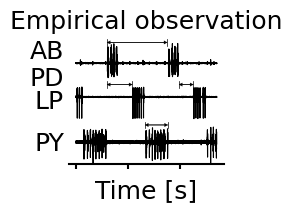

In [30]:
with mpl.rc_context(fname='.matplotlibrc'):
    mpl.rc('font',family='DejaVu Sans')
    fig, ax = plt.subplots(figsize=(2,1.75))
    make_obs_figure(ax)

In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'path'



def make_empirical_figure(ax, x_mean, x_map, fontsize=18):
    npz = np.load('trace_data_845_082_0044.npz')
    t = npz['t']
    PD_spikes = npz['PD_spikes']
    LP_spikes = npz['LP_spikes']
    PY_spikes = npz['PY_spikes']
    pdn = npz['pdn']
    lpn = npz['lpn']
    pyn = npz['pyn']
    start_index = 219500 + 2100
    end_index   = 246500 + 2100  # 32000
    height_offset = 200
    shown_t = t[end_index] - t[start_index]
    time_len = shown_t / 0.025 * 1000
    dt = t[1] - t[0]
    
    t = t-t[start_index]
    
    x_mean = x_mean / x_mean.max() + 1
    x_map = x_map / x_map.max() + 1
    
    t_sim = np.linspace(t[start_index], t[end_index], 161000-54000)
    
    # ax.plot(t_sim, 0.75+x_mean[0,0][55000:162000]*0.07, c="k", lw=0.8)
    # ax.plot(t_sim, 0.52+x_mean[0,1][55000:162000]*0.07, c="k", lw=0.8)
    # ax.plot(t_sim, 0.28+x_mean[0,2][55000:162000]*0.07, c="k", lw=0.8)
    
    ax.plot(t_sim, 0.85+x_mean[0,0][55000:162000]*0.07, c="k", lw=0.8)
    ax.plot(t_sim, 0.62+x_mean[0,1][55000:162000]*0.07, c="k", lw=0.8)
    ax.plot(t_sim, 0.35+x_mean[0,2][55000:162000]*0.07, c="k", lw=0.8)
    
    ax.plot(t_sim, 0.85+x_map[0,0][55000:162000]*0.07, c="C3", lw=0.8)
    ax.plot(t_sim, 0.62+x_map[0,1][55000:162000]*0.07, c="C3", lw=0.8)
    ax.plot(t_sim, 0.35+x_map[0,2][55000:162000]*0.07, c="C3", lw=0.8)
    
    line1 = mlines.Line2D([0,1],[0,1], color="black", label="Mean")
    line2 = mlines.Line2D([0,1],[0,1], color="C3", label="MAP")
    
    
    
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
    ax.set_yticks([0.39,0.66,0.89])
    ax.set_yticklabels(labels=["PY","LP", "AB\nPD"], fontsize=fontsize, fontname="DejaVu Sans")
    
    ax.set_ylim(0.25,1.1)
    
    ax.set_xlabel("Time [s]", fontsize=fontsize, fontname="DejaVu Sans")
    ax.set_title("Posterior mean/map", color="white", fontsize=fontsize, fontname="DejaVu Sans")
    
    
    ax.legend(handles=[line1,line2], ncol=2, fontsize=fontsize, bbox_to_anchor=(0.5, 1.0), bbox_transform=ax.transAxes, loc="center")
    
    sns.despine(fig, left=True)
    
    ax.tick_params(axis="y",length=0)
    # plt.savefig("figures/sunle_traces_map.pdf", transparent=True)

In [32]:
def make_frac_valid_samples_figure(ax, mets, mets_snle, fontsize=14):
    ax.plot(
        # list(range(len(mets_snle.frac_valid_obs_per_round))),
        list(map(lambda x: int(x/1000), mets_snle.num_simulations)),
        list(map(lambda x: x*100, mets_snle.frac_valid_obs_per_round)),
        color="royalblue",
        marker="o",
        label="SNVI",
        linewidth=3,
        markersize=5
    )

    ax.plot(
        # list(range(len(mets.frac_valid_obs_per_round))),
        list(map(lambda x: int(x/1000), mets.num_simulations)),
        list(map(lambda x: x*100, mets.frac_valid_obs_per_round)),
        color="firebrick",
        marker="o",
        label="S-UNLE (ours)",
        linewidth=3,
        markersize=5,
    )

    l = ax.legend(fontsize=fontsize, loc="center", ncol=2, bbox_to_anchor=(0.5, 1.2), bbox_transform=ax.transAxes)
    ax.set_ylim(0, 100)
    
    
    l.texts[1].set_weight("bold")
    
    
    
    ax.axhline(100 * np.max(mets.frac_valid_obs_per_round), color="firebrick", alpha=0.5, linestyle='--')
    ax.axhline(100 * np.max(mets_snle.frac_valid_obs_per_round), color="royalblue", alpha=0.5, linestyle='--')
    
    import matplotlib.ticker as mtick
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    
    
    ax.set_ylabel("% Valid Samples", fontsize=fontsize-4)
    # ax.set_xlabel("Round No.", fontsize=fontsize)

In [33]:
# ax.legend?

In [34]:
def make_energy_distance_figure(ax, mets, mets_snle, fontsize=14):
    ax.plot(
        list(map(lambda x: int(x/1000), mets_snle.num_simulations)),
        mets_snle.energy_values_z_scored_per_round,
        color="royalblue",
        marker="o",
        label="SNVI",
        linewidth=3,
        markersize=5
    )

    ax.plot(
        list(map(lambda x: int(x/1000), mets.num_simulations)),
        # mets.energy_values_z_scored_per_round,
        mets.energy_values_z_scored_per_round,
        color="firebrick",
        marker="o",
        label="S-UNLE",
        linewidth=3,
        markersize=5,
    )

    # ax.legend(fontsize=18)
    ax.set_ylim(0, 1.5)
    ax.tick_params(axis='y', which='major', pad=15)
    
    # ax.set_yticklabels([s._text + "  " for s in ax.get_yticklabels()])
    
    
    ax.axhline(np.min(mets.energy_values_z_scored_per_round), color="royalblue", alpha=0.5, linestyle='--')
    ax.axhline(np.min(mets_snle.energy_values_z_scored_per_round), color="firebrick", alpha=0.5, linestyle='--')
    
    
    ax.set_ylabel("Energy. Distance", fontsize=fontsize -4)
    ax.set_xlabel("Simulator Budget (x10³)", fontsize=fontsize)

In [35]:
# ax.get_yticklabels()[0]._text + " "

/tmp/ipykernel_807382/1141701857.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
/tmp/ipykernel_807382/3625544599.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


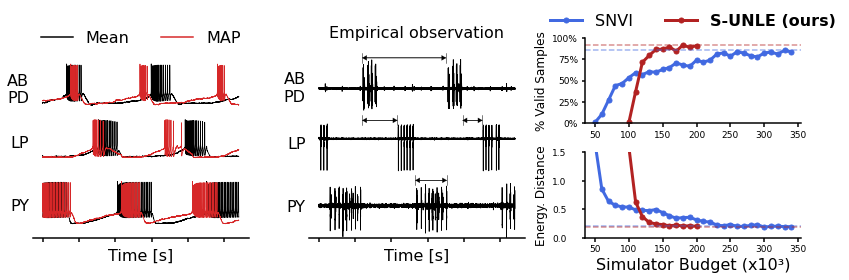

In [36]:
fig = plt.figure(figsize=(12, 4))
spec = fig.add_gridspec(2, 3)

with mpl.rc_context(fname='.matplotlibrc'):
    
    # fig, axs = plt.subplots(figsize=(3 * 5, 5), ncols=3, squeeze=False)
    
    mpl.rc('font',family='DejaVu Sans')
    # make_obs_figure(ax)
    ax_emp = fig.add_subplot(spec[:, 0])
    make_empirical_figure(ax_emp, x_mean, x_map, fontsize=16)
    
    ax_obs = fig.add_subplot(spec[:, 1])
    make_obs_figure(ax_obs, fontsize=16)
    
    ax_frac_vs = fig.add_subplot(spec[0, 2])
    make_frac_valid_samples_figure(ax_frac_vs, mets_sunle_100000, mets_snvi, fontsize=16)
    
    ax_energy_dist = fig.add_subplot(spec[1, 2])
    make_energy_distance_figure(ax_energy_dist, mets_sunle_100000, mets_snvi, fontsize=16)
    
    fig.tight_layout()
    

# fig.savefig("figures/fig_pyloric_100000.pdf")

/tmp/ipykernel_807382/1141701857.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
/tmp/ipykernel_807382/3625544599.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


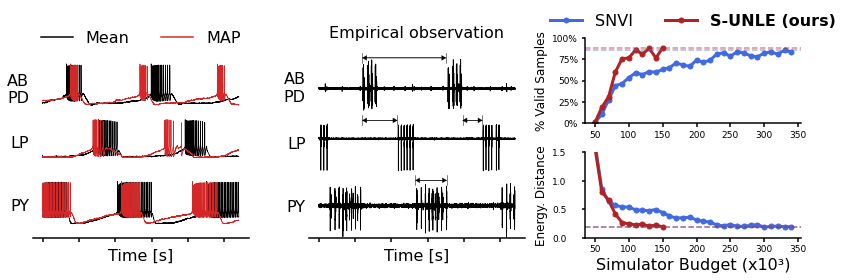

In [37]:
fig = plt.figure(figsize=(12, 4))
spec = fig.add_gridspec(2, 3)

with mpl.rc_context(fname='.matplotlibrc'):
    
    # fig, axs = plt.subplots(figsize=(3 * 5, 5), ncols=3, squeeze=False)
    
    mpl.rc('font',family='DejaVu Sans')
    # make_obs_figure(ax)
    ax_emp = fig.add_subplot(spec[:, 0])
    make_empirical_figure(ax_emp, x_mean, x_map, fontsize=16)
    
    ax_obs = fig.add_subplot(spec[:, 1])
    make_obs_figure(ax_obs, fontsize=16)
    
    ax_frac_vs = fig.add_subplot(spec[0, 2])
    make_frac_valid_samples_figure(ax_frac_vs, mets_sunle_50000, mets_snvi, fontsize=16)
    
    ax_energy_dist = fig.add_subplot(spec[1, 2])
    make_energy_distance_figure(ax_energy_dist, mets_sunle_50000, mets_snvi, fontsize=16)
    
    fig.tight_layout()
    

# fig.savefig("figures/fig_pyloric_50000.pdf")

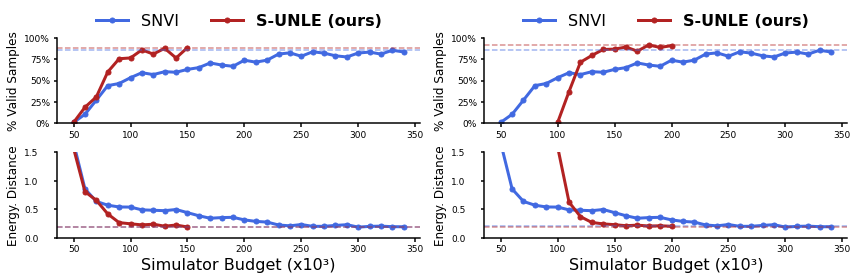

In [38]:

fig = plt.figure(figsize=(12, 4))

spec = fig.add_gridspec(2, 2)

with mpl.rc_context(fname='.matplotlibrc'):
    
    # fig, axs = plt.subplots(figsize=(3 * 5, 5), ncols=3, squeeze=False)
    
    mpl.rc('font',family='DejaVu Sans')
    
    ax_frac_vs_50000 = fig.add_subplot(spec[0, 0])
    make_frac_valid_samples_figure(ax_frac_vs_50000, mets_sunle_50000, mets_snvi, fontsize=16)
    
    ax_energy_dist_50000 = fig.add_subplot(spec[1, 0])
    make_energy_distance_figure(ax_energy_dist_50000, mets_sunle_50000, mets_snvi, fontsize=16)
    
    ax_frac_vs_100000 = fig.add_subplot(spec[0, 1])
    make_frac_valid_samples_figure(ax_frac_vs_100000, mets_sunle_100000, mets_snvi, fontsize=16)
     
    ax_energy_dist_100000 = fig.add_subplot(spec[1, 1])
    make_energy_distance_figure(ax_energy_dist_100000, mets_sunle_100000, mets_snvi, fontsize=16)
    
    fig.tight_layout()
    

fig.savefig("figures/fig_pyloric_50000_vs_100000.pdf")

In [92]:
# 
# fig = plt.figure(figsize=(12, 4))
# spec = fig.add_gridspec(2, 3)
# 
# with mpl.rc_context(fname='.matplotlibrc'):
#     
#     # fig, axs = plt.subplots(figsize=(3 * 5, 5), ncols=3, squeeze=False)
#     
#     mpl.rc('font',family='DejaVu Sans')
#     # make_obs_figure(ax)
#     ax_emp = fig.add_subplot(spec[:, 0])
#     make_empirical_figure(ax_emp, x_mean, x_map, fontsize=12)
#     
#     ax_obs = fig.add_subplot(spec[:, 1])
#     make_obs_figure(ax_obs, fontsize=12)
#     
#     ax_frac_vs = fig.add_subplot(spec[0, 2])
#     make_frac_valid_samples_figure(ax_frac_vs, mets_sunle_100000, mets_snvi, fontsize=12)
#     
#     ax_energy_dist = fig.add_subplot(spec[1, 2])
#     make_energy_distance_figure(ax_energy_dist, mets_sunle_100000, mets_snvi, fontsize=12)
#     
#     fig.tight_layout()
#     
# 
# # fig.savefig("figures/fig_pyloric.pdf")

# Marginal Pairplots

In [39]:
import jax.numpy as jnp
def reconstruct_theta(theta, theta_ij, i, j):
    theta = theta.at[i].set(theta_ij[0])
    return theta.at[j].set(theta_ij[1])


def make_renormalized_d_cond(d, theta_cond, posterior):
    def renormalized_d(tij):
        return d(posterior.z_transform.inv(reconstruct_theta(theta_cond, tij, i, j))[(i, j),])
    return renormalized_d

def make_renormalized_d(d, posterior, i, j):
    def renormalized_d(tij):
        thet = reconstruct_theta(jnp.zeros(posterior.event_shape), tij, i, j)
        return d(posterior.z_transform.inv(reconstruct_theta(jnp.zeros(posterior.event_shape), tij, i, j))[(i, j),])
    return renormalized_d

# from density_utils.plotting import make_unnormalized_kde_density
# d = make_unnormalized_kde_density(results.samples.xs, bandwidth=0.05)
# renormalized_d = make_renormalized_d(d, theta_cond)
# from jax import vmap
# tij_reconstruted = posterior.z_transform(vmap(lambda tij: reconstruct_theta(posterior.z_transform.inv(theta_cond), tij, i, j))(results.samples.xs[:, :]))[:, (i, j)]
# return renormalized_d, tij_reconstruted

In [41]:
ret_sunle = ret_sunle_50000

In [42]:
posterior_samples = ret_sunle.train_results.posterior_samples
posterior_samples_z_scored=ret_sunle.train_results.posterior.z_transform.inv(posterior_samples)

In [43]:
i = -7
j = -6
from density_utils.plotting import make_unnormalized_kde_density
dens = make_renormalized_d(make_unnormalized_kde_density(posterior_samples_z_scored[:, (i, j)], bandwidth=0.1), ret_sunle.train_results.posterior, i, j)

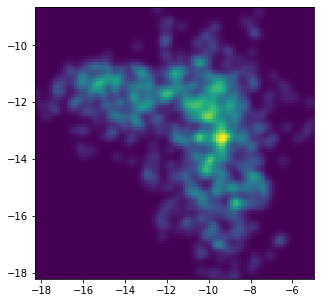

In [44]:
from density_utils.plotting import plot_densities
plot_densities({'d': dens}, 
               bounds=((posterior_samples.min(axis=0)[i], posterior_samples.max(axis=0)[i]),
                       (posterior_samples.min(axis=0)[j], posterior_samples.max(axis=0)[j]))
              )